# Basic experiments

# Import

In [3]:
import re

In [4]:
import torch
import numpy as np

In [5]:
import matplotlib.pyplot as plt

In [6]:
from scipy.stats import multivariate_normal

In [7]:
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [11]:
import sys

In [12]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [13]:
# Set seed for reproducibility
torch.manual_seed(42);

In [ ]:
# NOTE: adjust if you cloned these elsewhere
sys.path.append("src/DistributionalPrincipalAutoencoder")
sys.path.append("src/engression")
sys.path.append("src/mlcolvar")

In [87]:
from dpa.dpa_fit import DPA

In [88]:
from utils.plot_utils import plot_isolines_2D, plot_gradient_2D

In [89]:
def extract_first_numbers_after_epoch(filename):
    with open(filename, 'r') as file:
        text = file.read()

    pattern = r'\[Epoch (\d+)\]\s+([-*\d.]+)'
    matches = re.findall(pattern, text)
    numbers = np.array([(float(m1), float(m2)) for m1, m2 in matches])
    return numbers

In [90]:
class EncoderModule(torch.nn.Module):
    def __init__(self, trained_model, standardize=False, x_mean=None, x_std=None):
        super(EncoderModule, self).__init__()
        self.trained_model = trained_model
        self.trained_model.raw = trained_model.model
        self.encoder = self.trained_model.model.encoder
        if standardize is None:
            self.standardize = self.trained_model.standardize
        else:
            self.standardize = standardize
        if x_mean is None:
            self.x_mean = self.trained_model.x_mean
        else:
            self.x_mean = x_mean
        if x_std is None:
            self.x_std = self.trained_model.x_std
        else:
            self.x_std = x_std

        self.device = next(self.encoder.parameters()).device

    def forward(self, x, k=None, mean=True, gen_sample_size=100):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        x = x.to(self.device)

        if not x.requires_grad:
            x.requires_grad_(True)

        if self.standardize:
            x = (x - self.x_mean.to(self.device)) / self.x_std.to(self.device)

        if k is None:
            k = self.trained_model.latent_dim
        if self.trained_model.encoder_k:
            x = self.trained_model.get_k_embedding(k, x)

        z = self.encoder(x)
        return z[:, :k]

## Plot setup

In [14]:
import matplotlib as mpl

plt.style.use('default')
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['contour.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['axes.grid'] = False
mpl.rcParams['grid.alpha'] = 0.3
mpl.rcParams['grid.linewidth'] = 1
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 1.0
mpl.rcParams['legend.edgecolor'] = 'black'
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.pad_inches'] = 0.1

# 2D isotropic Gaussian

## The data

In [ ]:
# Number of points
N = 10_000

mean_torch = torch.tensor([0., 0.])
cov_torch = torch.tensor([[1., 0.],
                          [0., 1.]])

mvn = torch.distributions.MultivariateNormal(mean_torch, covariance_matrix=cov_torch)
X = mvn.sample((N,))

Load the data for reproducibility:

In [95]:
X = torch.load("data/2d_standard_gaussian.pt")

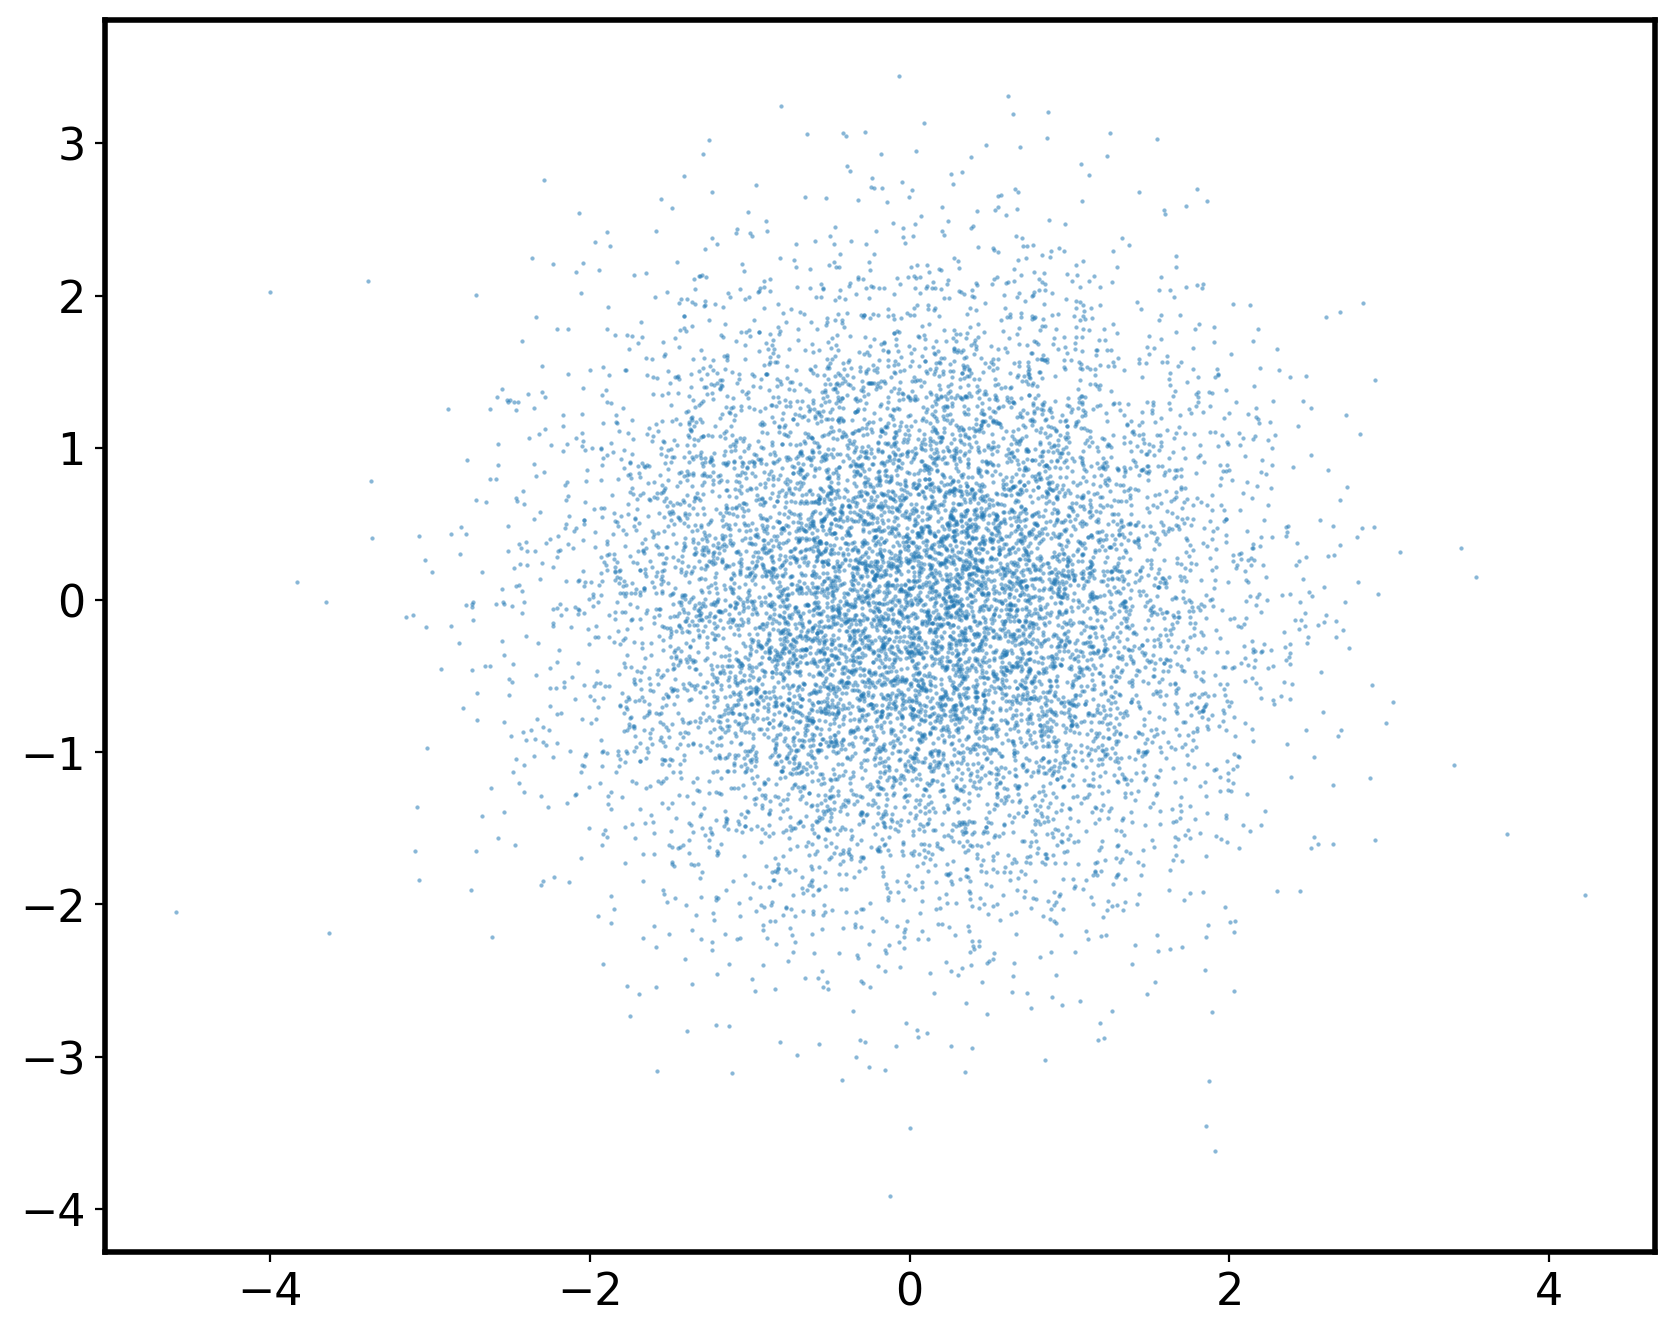

In [96]:
plt.scatter(X[:, 0], X[:, 1], s=0.3, alpha=0.5);

## The model

In [47]:
n_feats = X.shape[1]
k = 3
num_layer = 4
hidden_dim = 100
latent_dims = list(range(k + 1))[::-1]


In [48]:
prefix = f"res/models/gaussian/{k}k{num_layer}l{hidden_dim}h_old/"

In [49]:
dpaModel1 = DPA(
    beta=2,
    dist_enc="deterministic",
    dist_dec="stochastic",
    data_dim=n_feats,
    latent_dims=latent_dims,
    num_layer=num_layer,
    hidden_dim=hidden_dim,
    noise_dim=100,
    resblock=True,
    standardize=False,
    device=device,
    seed=42
)


GPU is available, running on GPU.



In [ ]:
dpaModel1.train(X,
                num_epochs=1000,
                lr=5e-4,
                batch_size=X.shape[0] // 3 + 1,
                save_model_every=100,
                save_dir=prefix,
                save_loss=True,
                resume_epoch=1000,
                )

## Plots

In [104]:
def gaussian_pdf(x, y):
    return 1 / (2 * np.pi) * np.exp(-0.5 * (x ** 2 + y ** 2))

In [52]:
dpaModel1.model.load_state_dict(torch.load(f"{prefix}/model_{700}.pt"))
dpaModel1.model = dpaModel1.model.to(device)
dpaModel1.model.eval();  # Set to evaluation mode
dpaeFunc1 = EncoderModule(dpaModel1)


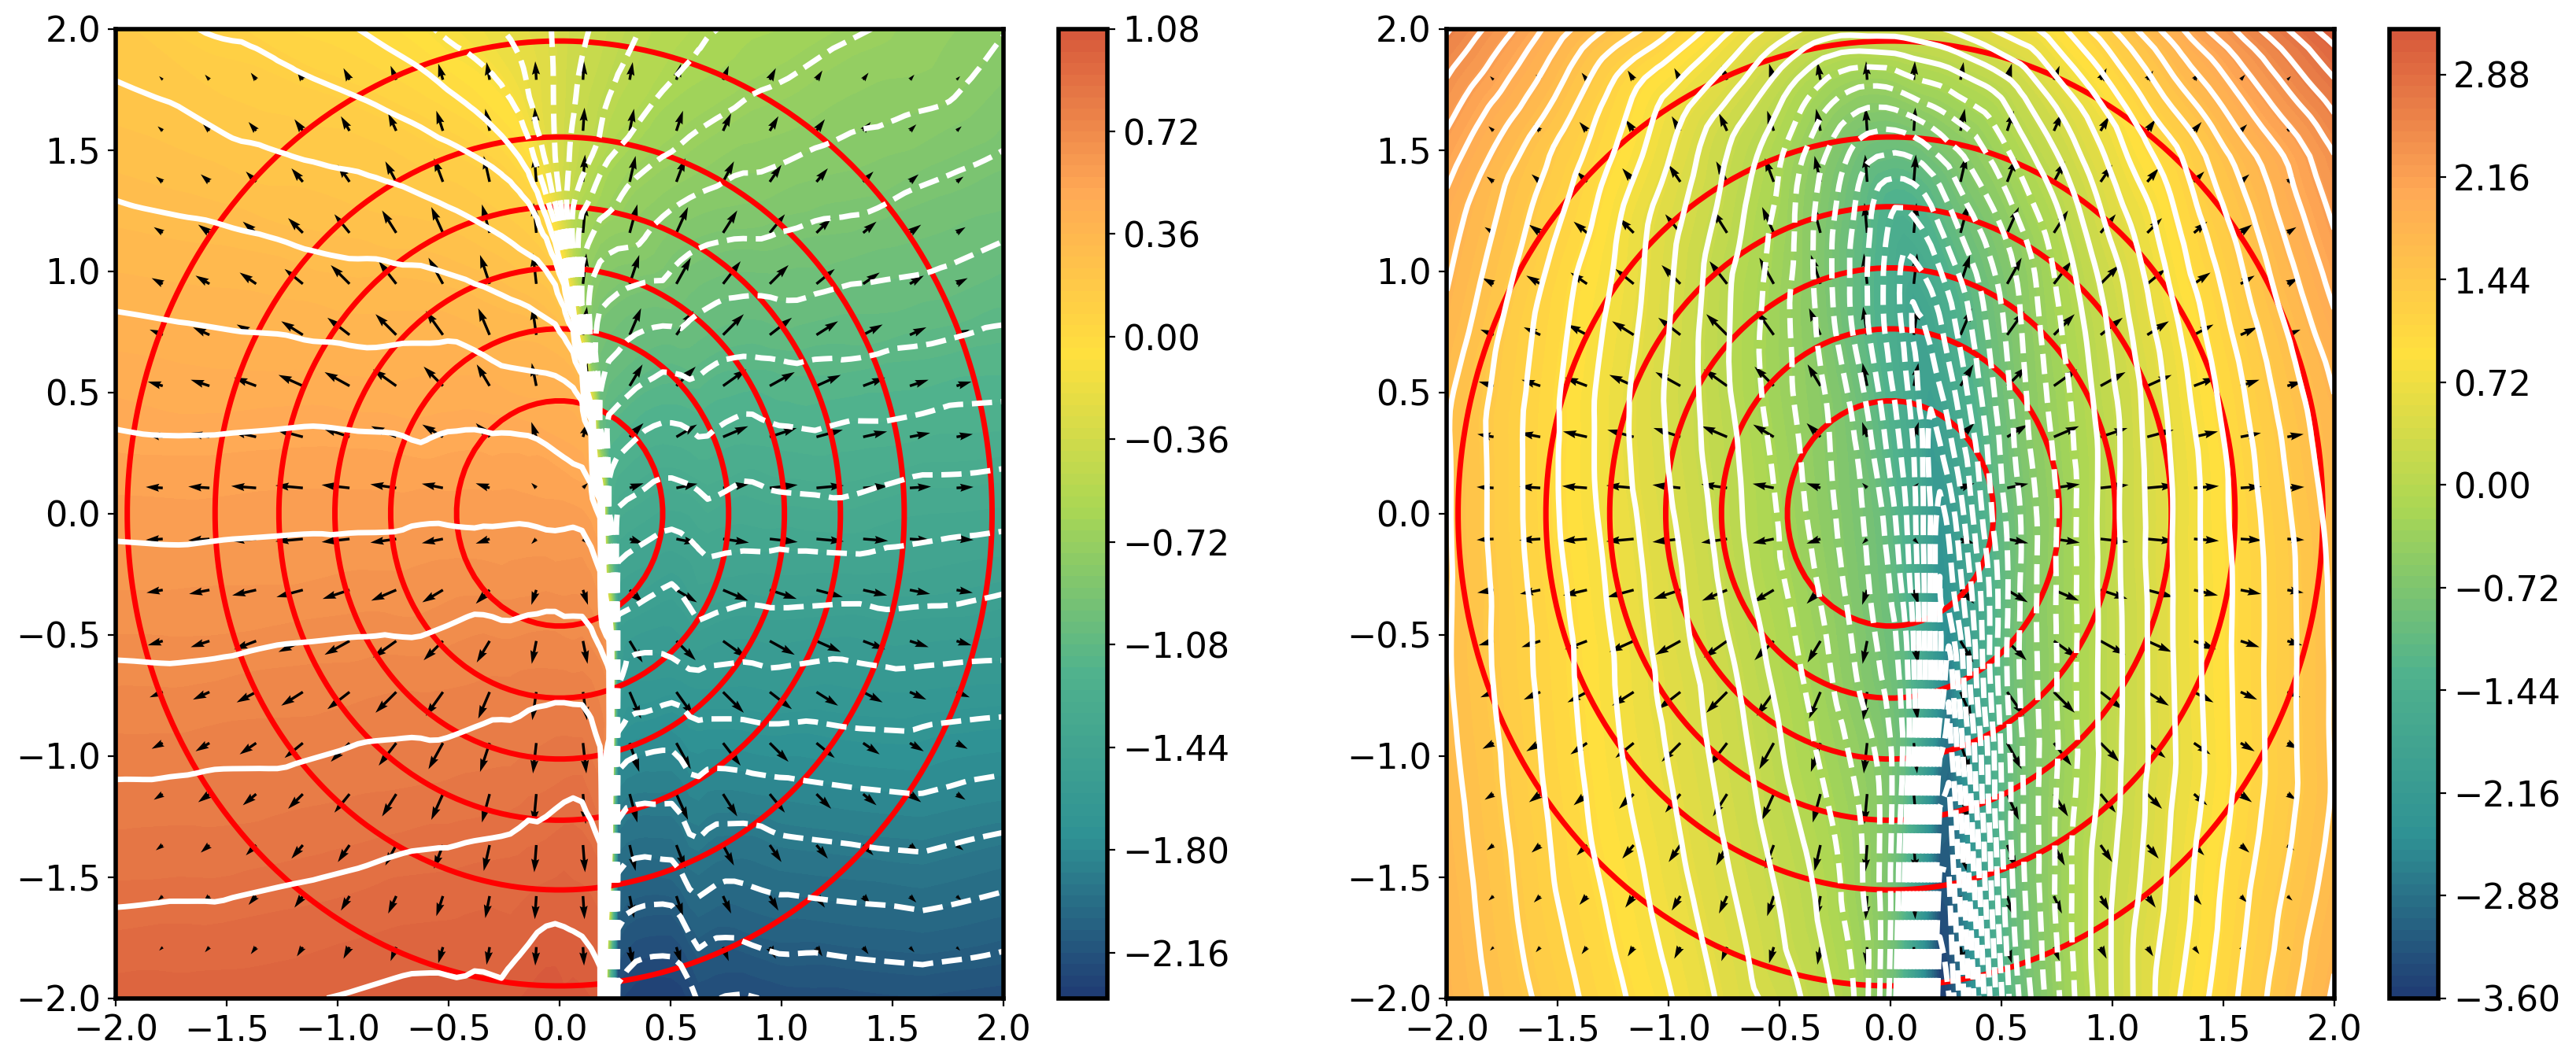

In [53]:
limits = ((-2, 2), (-2, 2))
n_components = 2

fig, axs = plt.subplots(1, n_components, figsize=(10 * n_components, 8))

plot_isolines_2D(gaussian_pdf,
                 levels=np.linspace(0, 1 / 3, 15),
                 limits=limits, mode='contour', ax=axs[0], colors="red")
plot_isolines_2D(dpaeFunc1, component=0, levels=100, ax=axs[0], limits=limits,
                 )
plot_isolines_2D(dpaeFunc1, levels=40, mode='contour', ax=axs[0], component=0,
                 colors="w",
                 limits=limits)
plot_gradient_2D(lambda x, y: -1. * gaussian_pdf(x, y), num_points=(20, 20), ax=axs[0], limits=limits,
                 color="k",
                 scale=.75, scale_units='xy');

plot_isolines_2D(gaussian_pdf,
                 levels=np.linspace(0, 1 / 3, 15),
                 limits=limits, mode='contour', ax=axs[1], colors="red")
plot_isolines_2D(dpaeFunc1, component=1, levels=100, ax=axs[1], limits=limits,
                 )
plot_isolines_2D(dpaeFunc1, component=1, levels=40, mode='contour', ax=axs[1],
                 colors="w",
                 limits=limits)
plot_gradient_2D(lambda x, y: -1. * gaussian_pdf(x, y), num_points=(20, 20), ax=axs[1], limits=limits,
                 color="k",
                 scale=.75, scale_units='xy');





# Mixture of Gaussians

## The data

In [ ]:
def sample_trimodal(n_samples=10000, weights=[1 / 3, 1 / 3, 1 / 3], means=np.array([[-1, -1], [1, -1], [0, 1]]),
                    sigma=0.5):
    mean1 = means[0]
    mean2 = means[1]
    mean3 = means[2]

    weights = np.array(weights)
    weights /= np.sum(weights)

    ns = (n_samples * np.array(weights)).astype(int)
    remainder = n_samples - np.sum(ns)

    # NOTE: assign any remainder to the first mode
    ns[0] += remainder

    samples1 = np.random.randn(ns[0], 2) * sigma + mean1
    samples2 = np.random.randn(ns[1], 2) * sigma + mean2
    samples3 = np.random.randn(ns[2], 2) * sigma + mean3

    samples = np.vstack([samples1, samples2, samples3])
    np.random.shuffle(samples)
    return samples

In [ ]:
means = np.array([[-1.1, -1.1], [1.1, -.9], [-0.33, 1]])
Xtr = sample_trimodal(n_samples=10000, weights=[1 / 3, 1 / 3, 1 / 3],
                      means=means,
                      sigma=0.66)
Xtr = torch.tensor(Xtr)

In [ ]:
# torch.save(Xtr, "data/2d_trimodal.pt", )

Load data for reproducibility

In [17]:
Xtr = torch.load("data/2d_trimodal.pt")

In [18]:
Xtr = Xtr.float()

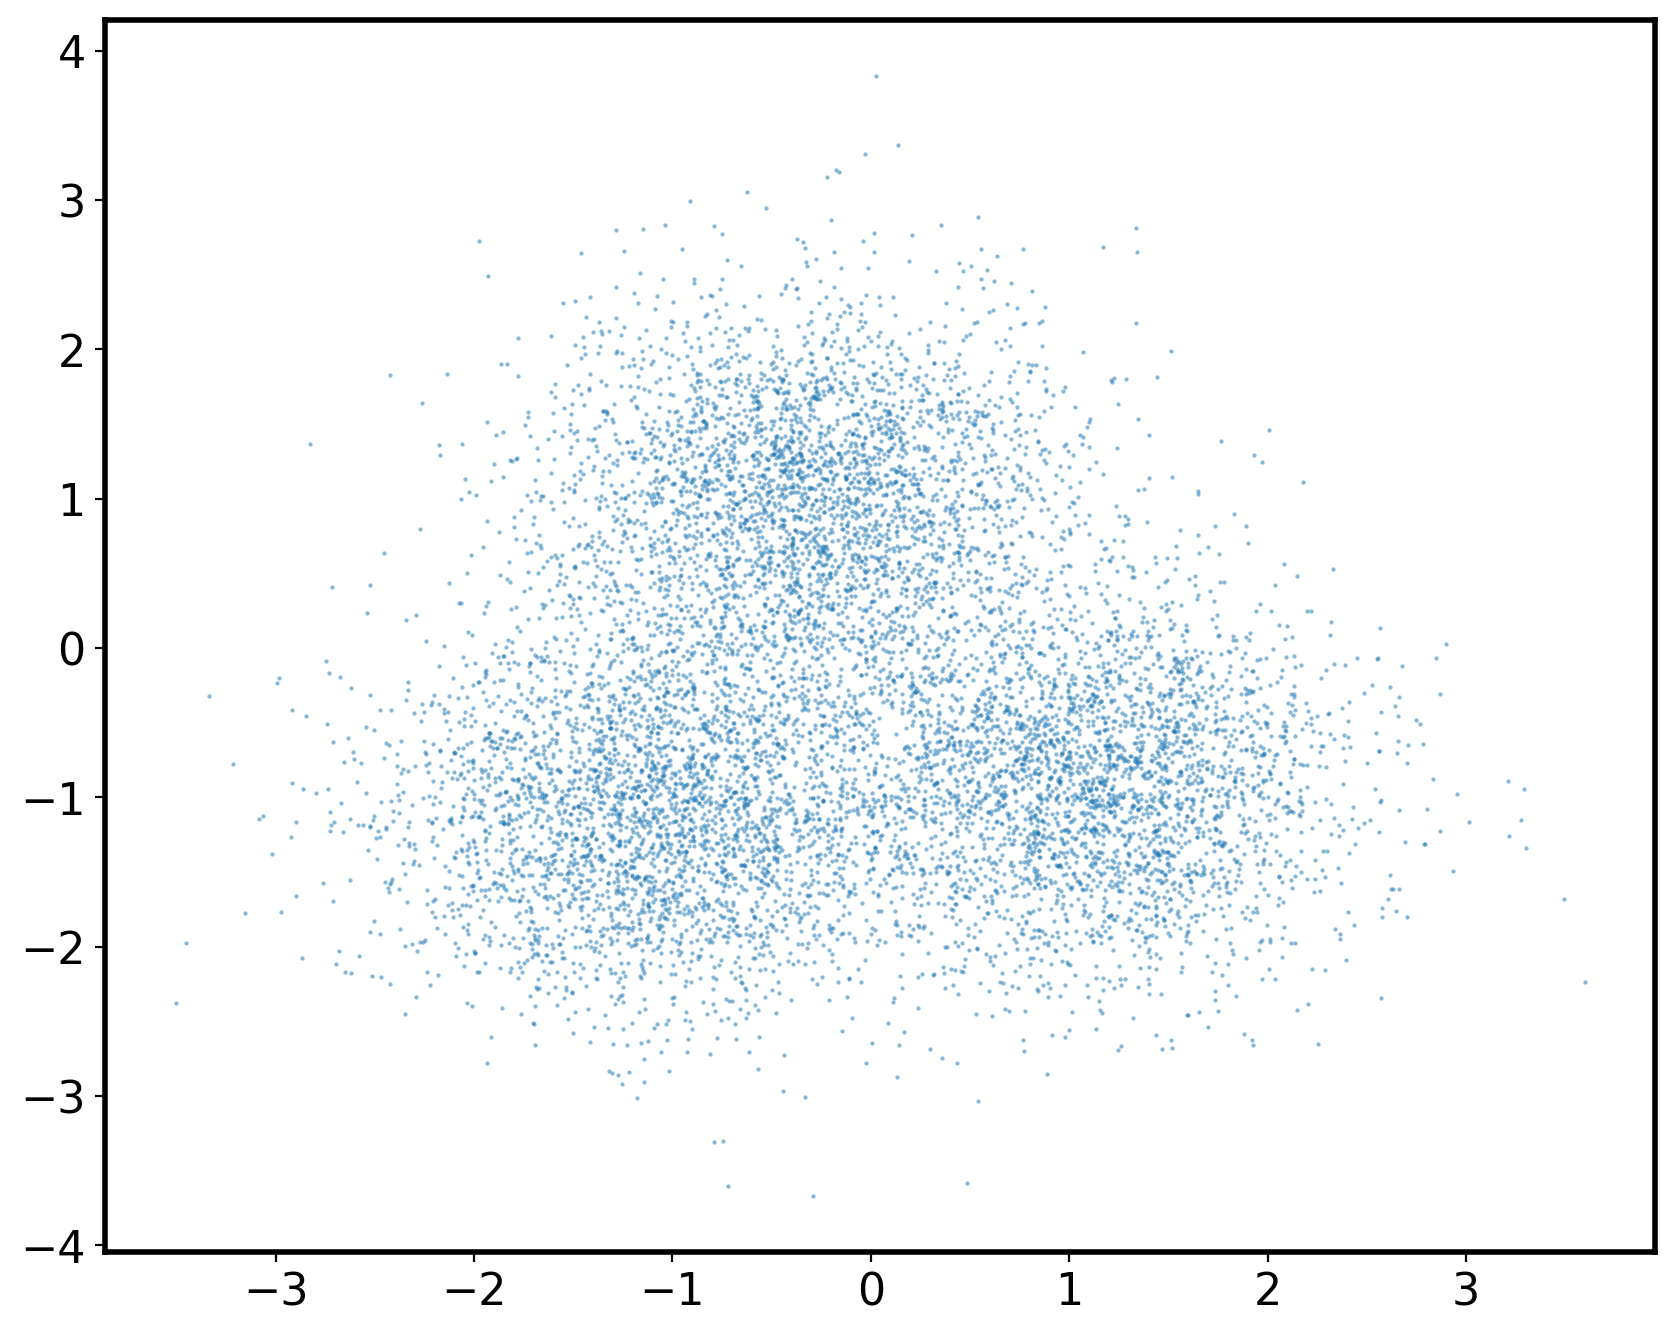

In [19]:
plt.scatter(Xtr[:, 0], Xtr[:, 1], s=0.3, alpha=0.5);

## The model

In [57]:
n_feats = Xtr.shape[1]
k = 2
num_layer = 4
hidden_dim = 100
latent_dims = list(range(k + 1))[::-1]


In [58]:
prefix = f"res/models/trimodal/{k}k{num_layer}l{hidden_dim}h/"

In [59]:
dpaModel3 = DPA(
    beta=2,
    dist_enc="deterministic",
    dist_dec="stochastic",
    data_dim=n_feats,
    latent_dims=latent_dims,
    num_layer=num_layer,
    hidden_dim=hidden_dim,
    noise_dim=100,
    resblock=True,
    device=device,
    seed=42,

    standardize=False,
)


GPU is available, running on GPU.



In [ ]:
dpaModel3.train(Xtr,
                num_epochs=2000,
                lr=5e-4,
                batch_size=Xtr.shape[0] // 3 + 1,
                save_model_every=100,
                save_dir=prefix,
                save_loss=True,
                )

## Plots

In [62]:
def trimodal_density(x, y, sigma=0.5, weights=[1 / 3, 1 / 3, 1 / 3], means=np.array([[-1, -1], [1, -1], [0, 1]])):
    mean1 = means[0]
    mean2 = means[1]
    mean3 = means[2]

    cov = sigma ** 2 * np.eye(2)

    rv1 = multivariate_normal(mean1, cov)
    rv2 = multivariate_normal(mean2, cov)
    rv3 = multivariate_normal(mean3, cov)

    weights = np.array(weights)
    weights /= np.sum(weights)

    density = (rv1.pdf(np.dstack((x, y))) * weights[0] +
               rv2.pdf(np.dstack((x, y))) * weights[1] +
               rv3.pdf(np.dstack((x, y))) * weights[2]
               )
    return density

In [60]:
dpaModel3.model.load_state_dict(torch.load(f"{prefix}/model_{1900}.pt"))
dpaModel3.model = dpaModel3.model.to(device)
dpaModel3.model.eval();
dpaeFunc3 = EncoderModule(dpaModel3)


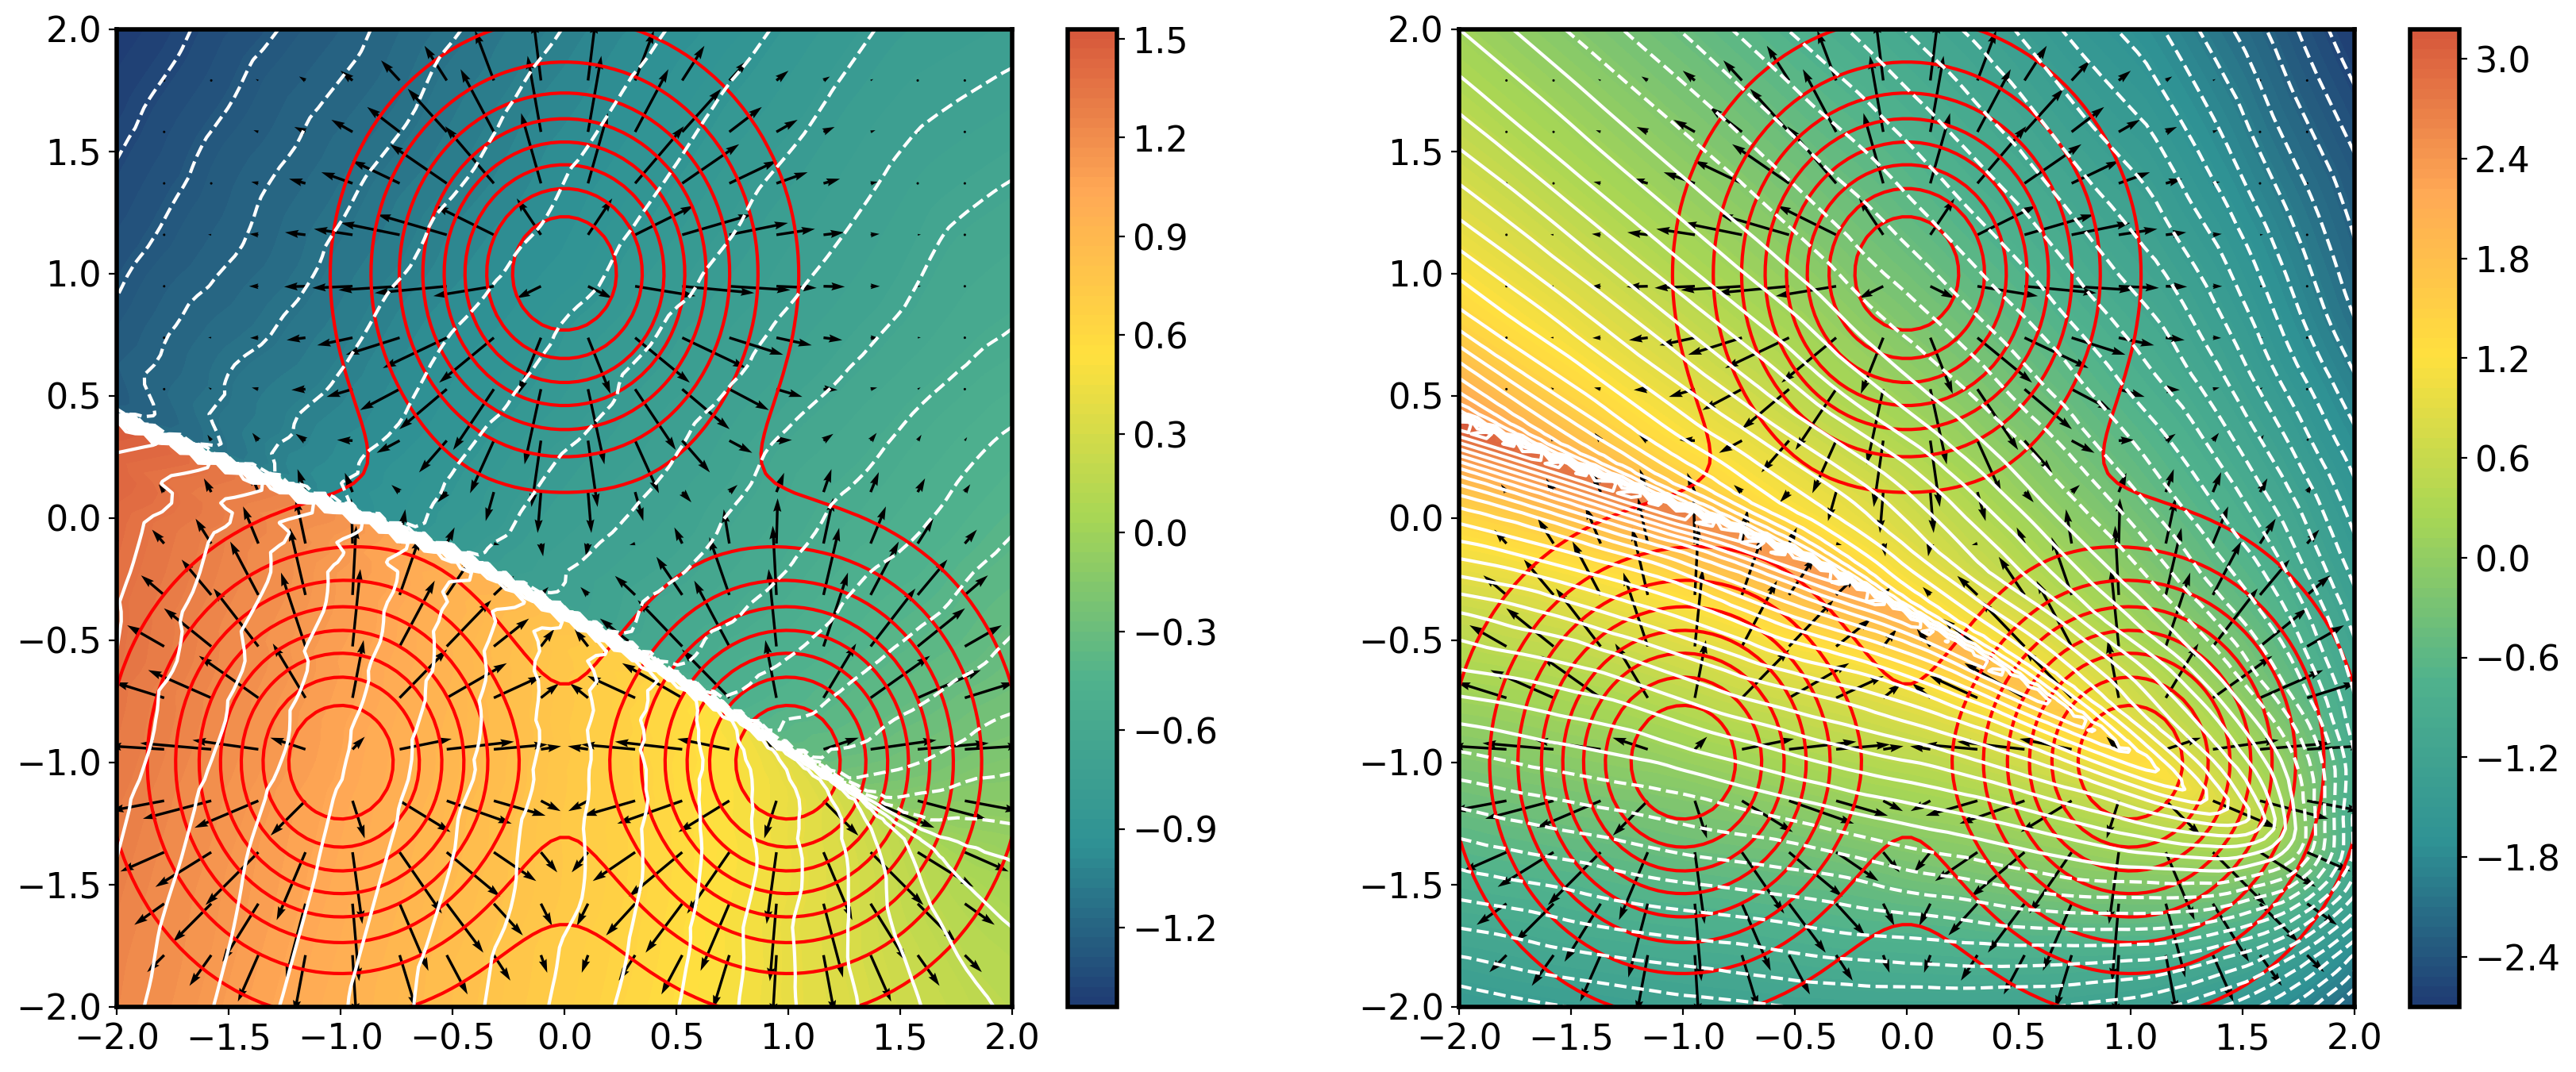

In [71]:
limits = ((-2, 2), (-2, 2))
n_components = 2

fig, axs = plt.subplots(1, n_components, figsize=(10 * n_components, 8))

plot_isolines_2D(trimodal_density,
                 levels=np.linspace(0, 1 / 3, 15),
                 limits=limits, mode='contour', ax=axs[0], colors="red")
plot_isolines_2D(dpaeFunc3, component=0, levels=100, ax=axs[0], limits=limits,
                 )
plot_isolines_2D(dpaeFunc3, levels=40, mode='contour', ax=axs[0], component=0,
                 colors="w",
                 limits=limits,
                 )
plot_gradient_2D(lambda x, y: -1. * trimodal_density(x, y), num_points=(20, 20), ax=axs[0], limits=limits,
                 color="k",
                 scale=.75, scale_units='xy');

plot_isolines_2D(trimodal_density,
                 levels=np.linspace(0, 1 / 3, 15),
                 limits=limits, mode='contour', ax=axs[1], colors="red")
plot_isolines_2D(dpaeFunc3, component=1, levels=100, ax=axs[1], limits=limits,
                 )
plot_isolines_2D(dpaeFunc3, component=1, levels=40, mode='contour', ax=axs[1],
                 colors="w",
                 limits=limits,
                 )
plot_gradient_2D(lambda x, y: -1. * trimodal_density(x, y), num_points=(20, 20), ax=axs[1], limits=limits,
                 color="k",
                 scale=.75, scale_units='xy');



